In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [42]:


# Load the dataset
file_path = "fraud_email_.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()
df.shape

(11929, 2)

In [43]:
# Check for missing values
print(df.isnull().sum())

# If missing values exist, decide on a strategy (drop or fill)
df = df.dropna()  # Drop missing values 
df.shape

Text     1
Class    0
dtype: int64


(11928, 2)

In [44]:
import re


# Define a list of common spam words
spam_keywords = [
    "win", "free", "urgent", "money", "prize", "lottery", "click", 
    "subscribe", "offer", "limited", "cash", "discount", "guaranteed","Congratulations"
]

# Function to extract features from email body
def extract_features(Text):
    if pd.isnull(Text):  # Handle missing values
        return 0, 0, 0
    
    #Word Count
    word_count = len(Text.split())

    #Number of Links (URLs)
    num_links = len(re.findall(r'https?://\S+', Text))

    #Spam Words Count
    spam_words = sum(Text.lower().count(word) for word in spam_keywords)

  

    return word_count, num_links, spam_words


In [45]:
# the dataset has a column named "email_body"
df[['word_count', 'num_links', 'spam_words']] = df['Text'].apply(lambda x: pd.Series(extract_features(str(x))))

In [46]:
df.rename(columns={"Class": "is_fraud"}, inplace=True)  # Change 'Class' to 'is_fraud' if needed
# Keep only relevant columns
df_final = df[['word_count', 'num_links', 'spam_words', 'is_fraud']]

# Save processed dataset
processed_file_path = "fraud_email1.csv"
df_final.to_csv(processed_file_path, index=False)

print(f"Processed dataset saved to: {processed_file_path}")
df_final.shape

Processed dataset saved to: fraud_email1.csv


(11928, 4)

In [47]:
# df.head()
df_final.head()

,word_count,num_links,spam_words,is_fraud
0,171,0,0,1
1,5,0,0,0
2,396,0,0,1
3,609,1,1,1
4,6,0,0,0


In [48]:
from sklearn.utils import resample

# Separate fraud and legit emails
df_fraud = df_final[df_final['is_fraud'] == 1]  # Fraud cases
df_legit = df_final[df_final['is_fraud'] == 0]  # Legitimate cases

# Downsample fraud cases to 20 samples
df_fraud_sampled = resample(df_fraud, replace=False, n_samples=20, random_state=42)

# Combine and shuffle
df_reduced = pd.concat([df_legit, df_fraud_sampled]).sample(frac=1, random_state=42)

# Check new class distribution
print(df_reduced['is_fraud'].value_counts())
df_reduced.to_csv("fraud_email1.csv",index=0)

is_fraud
0    6742
1      20
Name: count, dtype: int64


In [49]:
df = pd.read_csv("fraud_email1.csv")

df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6762 entries, 0 to 6761
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   word_count  6762 non-null   int64
 1   num_links   6762 non-null   int64
 2   spam_words  6762 non-null   int64
 3   is_fraud    6762 non-null   int64
dtypes: int64(4)
memory usage: 211.4 KB


,word_count,num_links,spam_words,is_fraud
0,33,0,0,0
1,23,0,0,0
2,18,0,0,0
3,1,0,0,0
4,13,0,0,0


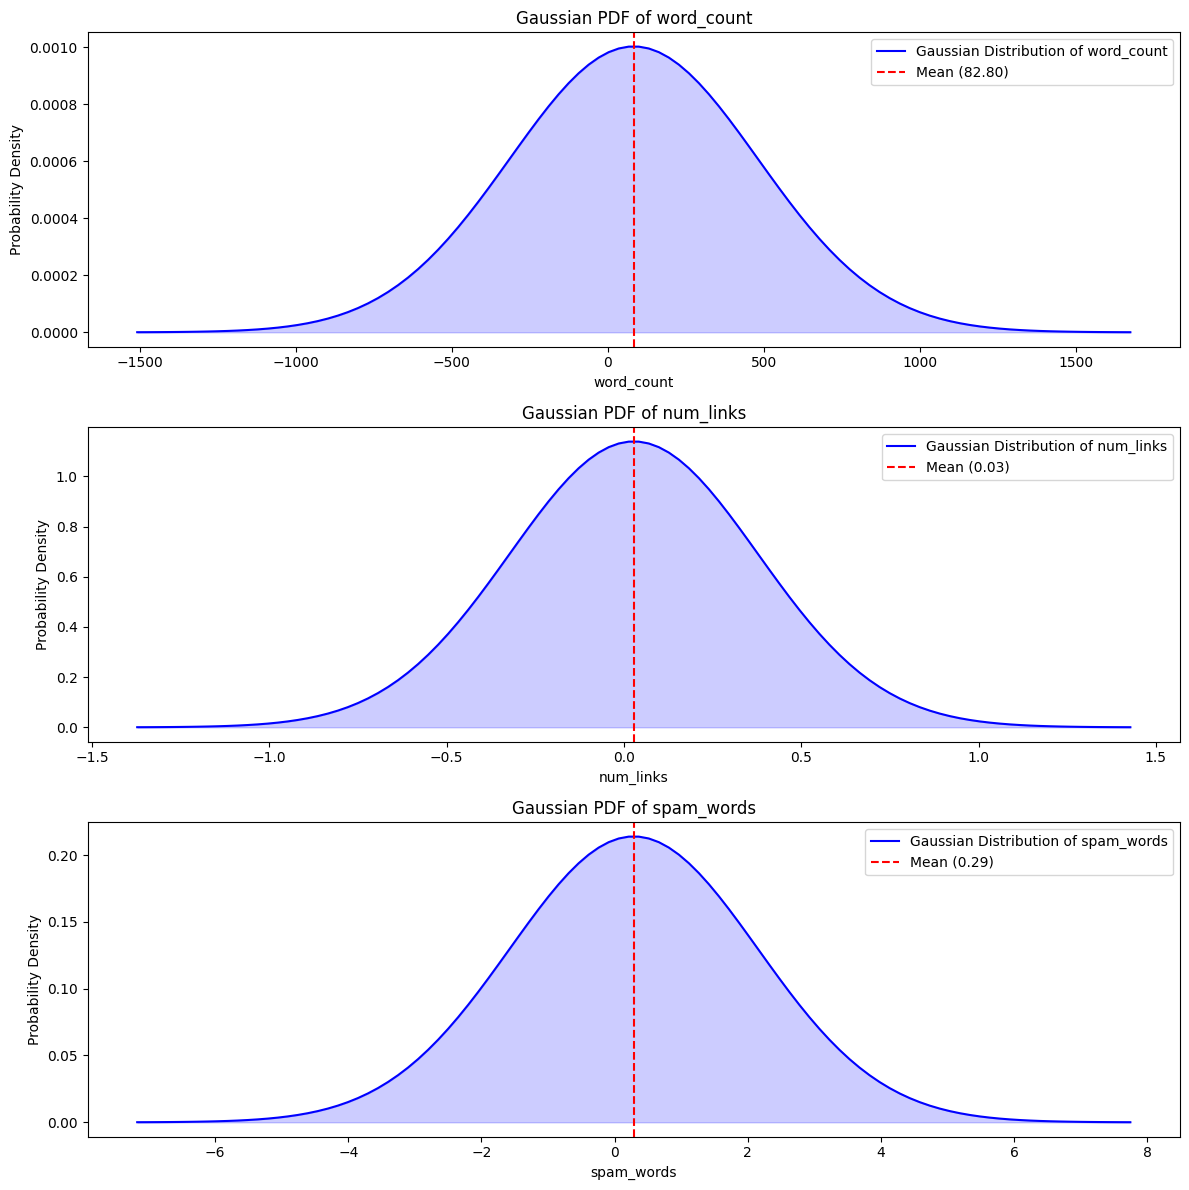

In [50]:
features = ["word_count", "num_links", "spam_words"]
# Set figure size
plt.figure(figsize=(12, 4 * len(features)))

# Loop through each feature and plot its Gaussian distribution
for i, feature in enumerate(features, 1):
    # Extract feature data
    data = df[feature].values
    
    # Compute mean and standard deviation
    mu, sigma = np.mean(data), np.std(data)
    
    # Create x values for the Gaussian PDF
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
    
    # Compute Gaussian PDF
    y = norm.pdf(x, mu, sigma)
    
    # Plot the probability distribution
    plt.subplot(len(features), 1, i)
    plt.plot(x, y, label=f'Gaussian Distribution of {feature}', color='blue')
    plt.axvline(mu, color='red', linestyle='dashed', label=f'Mean ({mu:.2f})')
    plt.fill_between(x, y, alpha=0.2, color='blue')  # Shaded region for density
    plt.xlabel(feature)
    plt.ylabel("Probability Density")
    plt.title(f'Gaussian PDF of {feature}')
    plt.legend()

# Show plots
plt.tight_layout()
plt.show()

In [51]:
from sklearn.preprocessing import StandardScaler

# Select only the feature columns (excluding is_fraud)
features = ['word_count', 'num_links', 'spam_words']
X = df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.015, random_state=42)

# Fit the model on the scaled features
iso_forest.fit(X_scaled)

# Predict anomalies (-1 = anomaly, 1 = normal)
df['anomaly_score'] = iso_forest.predict(X_scaled)

# Convert (-1 → 1 for Fraud, 1 → 0 for Legit)
df['anomaly_detected'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Show results
df[['is_fraud', 'anomaly_detected']].value_counts()

is_fraud  anomaly_detected
0         0                   6645
          1                     97
1         0                     15
          1                      5
Name: count, dtype: int64

### **Fraud Detection**

| **Metric**         | **Value** | **Description** |
|--------------------|----------|------------------------------------------------|
| **True Positives (TP)**  | 15  | Fraud emails correctly detected as fraud.    |
| **True Negatives (TN)**  | 6645 | Legitimate emails correctly identified as non-fraud. |
| **False Positives (FP)**  | 97  | Normal emails wrongly flagged as fraud.      |
| **False Negatives (FN)**  | 5  | Fraud emails missed by the model (classified as normal). |


### **Confusion Matrix**

In [53]:
# Define actual fraud labels and model predictions
y_true = df['is_fraud']            # Actual values
y_pred = df['anomaly_detected']    # Predicted values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels
labels = ["Legit (0)", "Fraud (1)"]


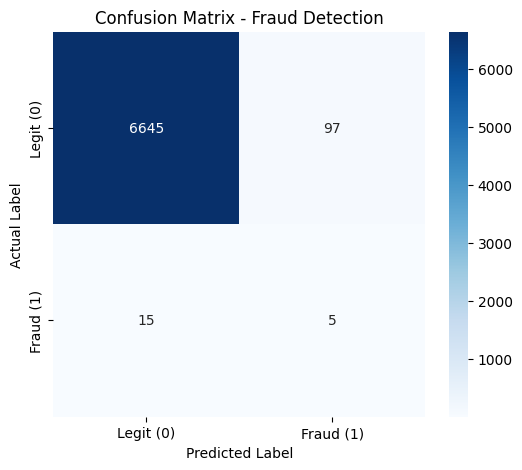

In [54]:
# Create a heatmap for visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Fraud Detection")
plt.show()


## **Model Evaluation Metrics**

| **Metric** | **Formula** | **Meaning** |
|------------|------------|-------------|
| **Accuracy** | (TP + TN)/(TP + TN + FP + FN) | % of correct predictions (both fraud & legit). |
| **Precision** | (TP)/(TP + FP) | How many of the predicted frauds were actually fraud? |
| **Recall (Sensitivity)** | (TP)/(TP + FN) | How many actual frauds were detected? |
| **F1 Score** | 2(Precision*Recall)/(Precision + Recall)| Balance between Precision & Recall. |

---


In [55]:
# Define actual and predicted values
y_true = df['is_fraud']            # Actual labels
y_pred = df['anomaly_detected']    # Predicted labels

# Compute Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9834
Precision: 0.0490
Recall: 0.2500
F1 Score: 0.0820


### **Guassian Distribution of each feature**

In [56]:
features = ["word_count", "num_links", "spam_words"]


### **Scatter Plot of the density distribution**

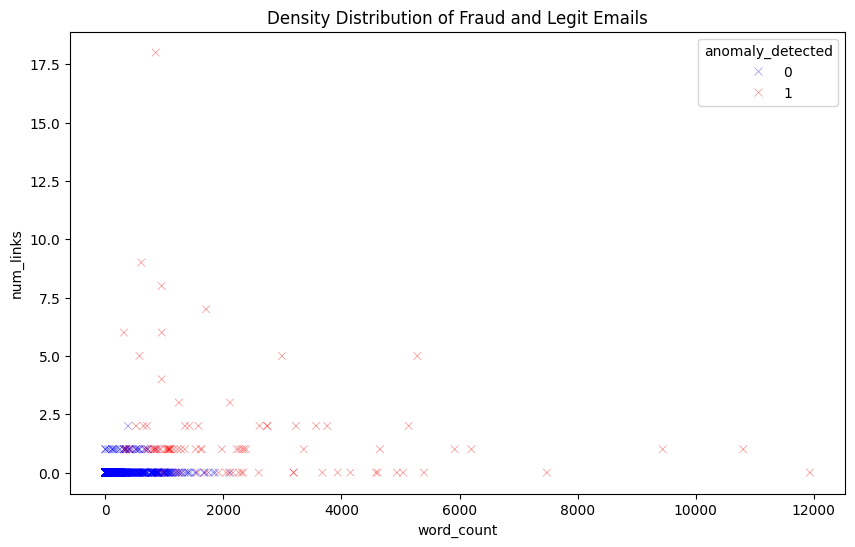

In [57]:
# Select two features for visualization
X_feature = "word_count"   # X-axis
Y_feature = "num_links"    # Y-axis
Z_label = "anomaly_detected"  # Fraud label (0 = Legit, 1 = Fraud)

# Set figure size
plt.figure(figsize=(10, 6))

# Plot scatterplot with density estimation
sns.scatterplot(
    data=df, 
    x=X_feature, 
    y=Y_feature, 
    hue=Z_label,  # Color by fraud label
    palette={0: "blue", 1: "red"},  # Blue for legit, red for fraud
    alpha=0.5,  # Transparency
    marker='x',
    s=30
)

# Add labels and title
plt.xlabel(X_feature)
plt.ylabel(Y_feature)
plt.title("Density Distribution of Fraud and Legit Emails")

# Show plot
plt.show()


### **Predictions for wheather the email is fraud or not**

In [58]:


def predict_email_fraud(email_text):
    """
    Takes an email's raw text, extracts features, and predicts if it's spam or legit.
    """
    # Extract numerical features from the email text
    word_count, num_links, spam_words = extract_features(email_text)
    
    # Convert to Pandas DataFrame with the same feature names
    new_email_df = pd.DataFrame([[word_count, num_links, spam_words]], 
                                columns=["word_count", "num_links", "spam_words"])
    
    # Scale the new email's features
    new_email_scaled = scaler.transform(new_email_df)
    
    # Make a prediction using the trained Isolation Forest model
    prediction = iso_forest.predict(new_email_scaled)
    
    # Interpret the result
    result = "❌ Spam Email (Fraud)" if prediction[0] == -1 else "✅ Legit Email"
    
    # Print extracted feature values for reference
    print(f"Extracted Features - Word Count: {word_count}, Links: {num_links}, Spam Words: {spam_words}")
    
    return result



In [59]:
email1 = """Hello John,
Hope you are doing well. Let's schedule a meeting for tomorrow at 10 AM.
Best, Alice
"""
email2 = """Congratulations! 🎉 You have won a FREE prize. Click here to claim your money now: http://fakeoffer.com
Act fast before the offer expires!
"""

In [62]:
predict_email_fraud(email1)



Extracted Features - Word Count: 18, Links: 0, Spam Words: 0


'✅ Legit Email'

In [63]:
predict_email_fraud(email2)

Extracted Features - Word Count: 22, Links: 1, Spam Words: 6


'❌ Spam Email (Fraud)'